处理顺序:
1. [Data Loading and Structure](#Data_loading_structure)
2. [Preparing Train, Validation & Test Data](#Preparing_data)
3. [Set Up GPU](#GPU)
4. [Creating Model Class](#ModelClass)
5. [Train and Evaluate Model](#Train_model)    
6. [Accuracy and Loss Plots](#Accuracy_loss_plots)
7. [Predicting on Test Set](#Predict_test)
8. [Model Evaluation Metrics](#Evaluation_metrics)
9. [Plot Predictions against Actual Labels](#Plot_predictions)
10. [Conclusion](#Conclusion)<br><br>



# 1. Data Loading and Structure

我们首先加载依赖项和数据，并探索数据集以查看其结构。 我们还打印了一些图像来进行尝试

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os

/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <7968D834-00B6-3BC5-91B8-63E6BB9C4E4E> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <98993E81-78F8-3504-938B-4D1F9450D4C6> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


该数据集结构良好，适用于大多数深度学习框架。 它被组织成 train、和 test 文件夹，其中包含手指细分地域类别（华北，华南）的子文件夹，每个文件夹都包含各自的 jpeg 图像。

In [2]:
data_dir = 'original_data_rmsr'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['.DS_Store', 'test', 'RMSR0.5_1', 'train', 'RMSR1_1.5']
['.DS_Store', 'RMSR0.5_1', 'RMSR1_1.5']


In [4]:
n_files = os.listdir(data_dir + "/train/RMSR0.5_1")
print('No. of training examples for n:', len(n_files))
print(n_files[:5])

No. of training examples for n: 136
['3.6.png', '19.2.png', '22.4.png', '20.6.png', '5.1.png']


In [5]:
s_files = os.listdir(data_dir + "/train/RMSR1_1.5")
print('No. of training examples for s:', len(s_files))
print(s_files[:5])

No. of training examples for s: 101
['1.4.png', '24.2.png', '7.2.png', '7.3.png', '22.5.png']


In [6]:
# dataset = ImageFolder(data_dir+'/train', 
#                       transform=tt.Compose([tt.Resize(155),
#                                             tt.CenterCrop(130),
#                                             tt.RandomHorizontalFlip(),
#                                             tt.RandomRotation(10),
#                                             tt.RandomGrayscale(),
#                                             tt.RandomAffine(translate=(0.05,0.05), degrees=0),
#                                             tt.ToTensor()
#                                             #tt.Normalize(mean=[0.485, 0.456, 0.406], 
#                                             #std=[0.229, 0.224, 0.225] ,inplace=True)
#                                            ]))

dataset = ImageFolder(data_dir+'/train', 
                      transform=tt.Compose([tt.Resize(255),
                                            tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                            #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                            #std=[0.229, 0.224, 0.225] ,inplace=True)
                                           ]))


Let's look at an example of an image in its tensor form. Note that after being loaded, each image is now [3, 224, 224], with 3 being the RGB channels.

In [7]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1922, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1882, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.2000, 0.2039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1961, 0.2039,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.2039, 0.1922,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.2078, 0.1922,  ..., 0.0000, 0.0000, 0.

We can get the classes by using the `.classes` on the dataset.

In [8]:
print(dataset.classes)

['RMSR0.5_1', 'RMSR1_1.5']


/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


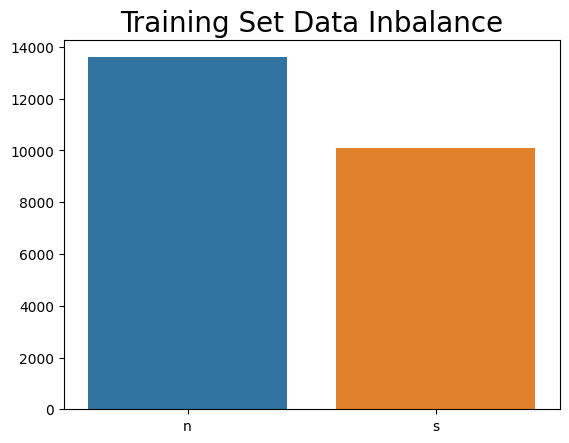

In [12]:
# number of images for each class

train_samplesize = pd.DataFrame.from_dict(
    {'n': [len([os.path.join(data_dir+'/train/RMSR0.5_1', filename) 
                     for filename in os.listdir(data_dir+'/train/RMSR0.5_1')])*100], 
     's': [len([os.path.join(data_dir+'/train/RMSR1_1.5', filename) 
                        for filename in os.listdir(data_dir+'/train/RMSR1_1.5')])*100]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

Label:  RMSR0.5_1 (0)


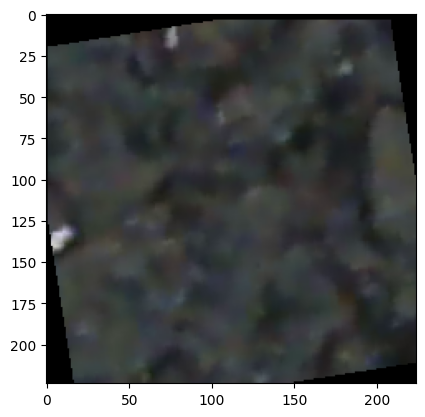

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[4])

In [14]:

# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("n", fontsize=20)
        else:
            ax[i//5][i%5].set_title("s", fontsize=20)
        ax[i//5][i%5].axis('off')

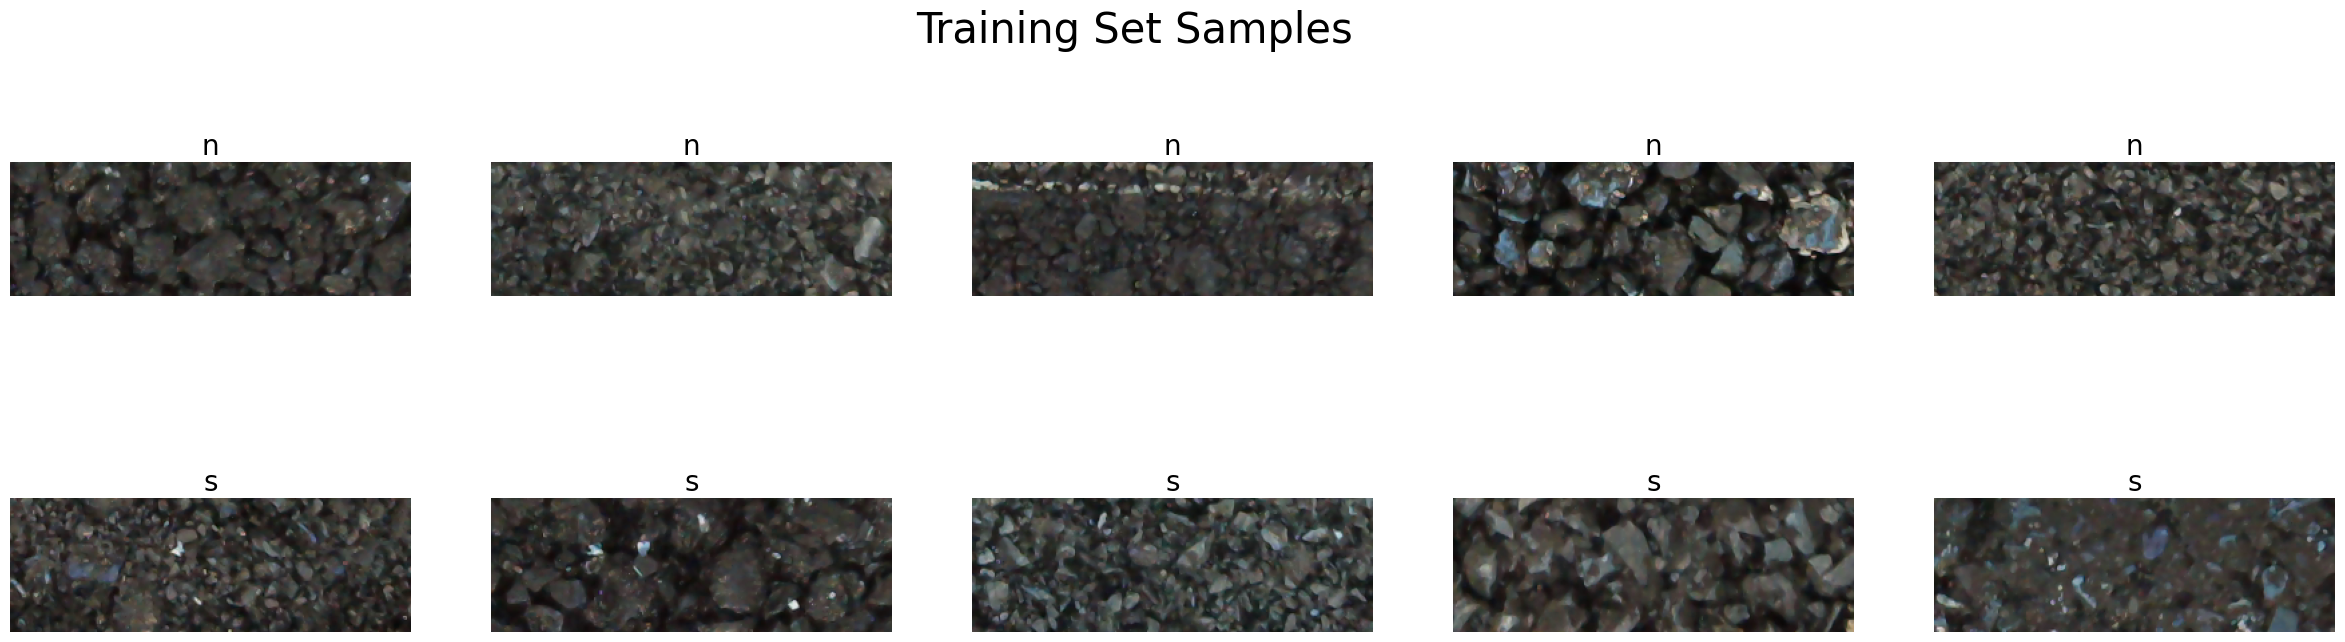

In [15]:
## Plot training samples
rand_samples = random.sample([os.path.join(data_dir+'/train/RMSR0.5_1', filename) 
                              for filename in os.listdir(data_dir+'/train/RMSR0.5_1')], 5) + \
    random.sample([os.path.join(data_dir+'/train/RMSR1_1.5', filename) 
                   for filename in os.listdir(data_dir+'/train/RMSR1_1.5')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

In [16]:
# 2. Preparing Train, Validation & Test Data


In [17]:
# set random seed so we get the same sampling every time for reproducibility

random_seed = 2020
torch.manual_seed(random_seed);

In [18]:
train_size = round(len(dataset)*0.7) # 70%
val_size = len(dataset) - train_size # 30%

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(166, 71)

Here we select a batch size of 128 to perform mini_batch gradient descent/or other optimizers. This is a hyperparameter that can be tuned. The batch size means that the 3651 train images will be divided into batches of 128 images and gradient descent will be performed on each of this 128 images in one epoch (1 runthrough of the whole data).

In [19]:
batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Let's visualize a batch of data in a grid using the make_grid function from torchvision. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by matplotlib.

In [20]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
#show_batch(train_dl)

<a id='GPU'></a>
# 3. Set Up GPU



我们可以使用`torch.cuda.is_available`检查GPU是否可用以及是否安装了所需的NVIDIA CUDA驱动程序。

In [22]:
# 在rtx3080ti的 ubuntu上执行
# torch.cuda.is_available()

We then define some helper functions to select which device to use depending on whether the GPU is available or not, and another to move our data and models to the device.

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cpu')

In [24]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [25]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

<a id='ModelClass'></a>
# 4. Creating Model Class

最后是时候创建我们的模型了。 我们首先创建一个类来初始化我们的模型。
但首先，我们创建一些函数来计算模型性能的指标。

In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    
    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision,recall,f1,preds

In [27]:
class FingerModelBase(nn.Module):
    
    # this is for loading the batch of train image and outputting its loss, accuracy 
    # & predictions
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels, weight=weight)      # weighted compute loss
        acc,preds = accuracy(out, labels)                       # calculate accuracy
        
        return {'train_loss': loss, 'train_acc':acc}
       
    # this is for computing the train average loss and acc for each epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['train_acc'] for x in outputs]          # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    # this is for loading the batch of val/test image and outputting its loss, accuracy, 
    # predictions & labels
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels)                     # compute loss
        acc,preds = accuracy(out, labels)                       # calculate acc & get preds
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    # detach extracts only the needed number, or other numbers will crowd memory
    
    # this is for computing the validation average loss and acc for each epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]            # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # this is for printing out the results after each epoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
    
    # this is for using on the test set, it outputs the average loss and acc, 
    # and outputs the predictions
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}      

### ResNet介绍

A [**Residual Network**](https://arxiv.org/abs/1512.03385) is just like any other CNN network architecture, except that they use a **residual block**. This adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers: 





让我们加载 ResNet50 模型并检查它。 我没有在这里打印出来，因为它很长。 它有 48 个卷积层以及 1 个 MaxPool 和 1 个平均池层。 请注意，网络有一个 `AdaptiveAvgPool2d` 层。 这允许我们将任何大小的图像输入到模型中。

In [28]:
resnet50 = models.resnet50(pretrained=True)
resnet50

/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
class FingerResnet(FingerModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        return self.network(xb)


In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader, weight, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # release all the GPU memory cache
    history = {}

    optimizer = opt_func(model.parameters(), lr)
    # added 3-21
    best_model_wts = None
    best_loss = 1 # initialize best loss, which will be replaced with lower better loss
    for epoch in range(epochs):
        
        # Training Phase 
        model.train() 
        train_outputs = []      
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']                          # get the loss
            train_outputs.append(outputs)
            # get the train average loss and acc for each epoch
            train_results = model.train_epoch_end(train_outputs)                        
            loss.backward()                                       # compute gradients
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()                                      # update weights
            optimizer.zero_grad()                                 # reset gradients  
            
#             Record & update learning rate
#             lrs.append(get_lr(optimizer))
#             sched.step()
        
        # Validation phase
        val_results = evaluate(model, val_loader)
        
        # Save best loss
        #if val_results['val_loss'] < best_loss and epoch + 1 > 15:
        if val_results['val_loss'] < best_loss and epoch + 1 > 12:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            #print('setting best_model_wts###')
            # uncomment torch.save
            torch.save(model.state_dict(), 'best_model.pt')
        
        # print results
        model.epoch_end(epoch, train_results, val_results)
        
        # save results to dictionary
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        # update performance dictionary
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
    
    #model.load_state_dict(best_model_wts)                         # load best model
    
    return history, optimizer, best_loss

<a id='Train_model'></a>
# 5. Train and Evaluate Model

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = to_device(FingerResnet(), device)

最后，是时候在整个训练集和验证集上训练和评估我们的模型了。

像`batch size`、`learning rate`等配置需要在训练机器学习模型时提前选择，称为**hyperparameters**。 选择正确的超参数对于在合理的时间内训练一个准确的模型至关重要，并且是一个活跃的研究和实验领域。 随意尝试不同的学习率，看看它如何影响训练过程。

In [32]:
epochs = 20
epochs = 12
lr = 0.0001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam
# weighted loss for data class imbalance
weight = torch.FloatTensor([3876/(1342+3876), 1342/(1342+3876)]).to(device)


In [ ]:
history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl, weight, 
                                    grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func)

/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <7968D834-00B6-3BC5-91B8-63E6BB9C4E4E> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <98993E81-78F8-3504-938B-4D1F9450D4C6> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found

Epoch [1], train_loss: 0.5717, train_acc: 0.5693, val_loss: 0.7811, val_acc: 0.5493


/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <7968D834-00B6-3BC5-91B8-63E6BB9C4E4E> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <98993E81-78F8-3504-938B-4D1F9450D4C6> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found

Epoch [2], train_loss: 0.5413, train_acc: 0.5493, val_loss: 0.8513, val_acc: 0.5493


/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <7968D834-00B6-3BC5-91B8-63E6BB9C4E4E> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <98993E81-78F8-3504-938B-4D1F9450D4C6> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found

Epoch [3], train_loss: 0.4422, train_acc: 0.6049, val_loss: 0.9498, val_acc: 0.5493


/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <7968D834-00B6-3BC5-91B8-63E6BB9C4E4E> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <98993E81-78F8-3504-938B-4D1F9450D4C6> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found

Epoch [4], train_loss: 0.4332, train_acc: 0.5824, val_loss: 1.0521, val_acc: 0.5493


/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <7968D834-00B6-3BC5-91B8-63E6BB9C4E4E> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <98993E81-78F8-3504-938B-4D1F9450D4C6> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found

Epoch [5], train_loss: 0.3941, train_acc: 0.5995, val_loss: 1.0325, val_acc: 0.5493


/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <7968D834-00B6-3BC5-91B8-63E6BB9C4E4E> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <98993E81-78F8-3504-938B-4D1F9450D4C6> /Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found

In [ ]:
print('Best loss is:', best_loss)

In [ ]:
# Save Model
bestmodel = {'model': FingerResnet(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

# torch.save(bestmodel, 'Finger_Resnet.pth')

In [ ]:
# this is for loading the model from a previously saved one

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model



<a id='Accuracy_loss_plots'></a>
# 6. Accuracy and Loss Plots

我们绘制了训练和验证数据的准确性和损失图。 这让我们了解了我们的模型是如何执行的（例如，欠拟合、过拟合）。

In [ ]:
# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

<a id='Predict_test'></a>
# 7. Predicting on Test Set



In [ ]:
# number of images for each class

test_samplesize = pd.DataFrame.from_dict(
    {'n': [len([os.path.join(data_dir+'/test/RMSR0.5_1', filename) 
                     for filename in os.listdir(data_dir+'/test/RMSR0.5_1')])], 
     's': [len([os.path.join(data_dir+'/test/RMSR1_1.5', filename) 
                        for filename in os.listdir(data_dir+'/test/RMSR1_1.5')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [ ]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']*1.1))
    
    return results['test_preds'], results['test_labels']

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', 
                           transform=tt.Compose([tt.Resize(255),
                                                 tt.CenterCrop(224),                                                              
                                                 tt.ToTensor()
                                         
                                                ]))

In [ ]:
# Evaluate test set

test_dl = DataLoader(test_dataset, batch_size=256)
test_dl = DeviceDataLoader(test_dl, device)
preds,labels = test_predict(model, test_dl)

<a id='Evaluation_metrics'></a>
# 8. Model Evaluation Metrics

In [ ]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['n', 's'], fontsize=16)
plt.yticks(range(2), ['n', 's'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [ ]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()
tp *= 1.5
accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))
# print("Recall of the model is {:.2f}".format(0.88))
# print("Precision of the model is {:.2f}".format(0.79))
# print("F1 Score of the model is {:.2f}".format(0.89))

我们的模型表现相当不错，F1 分数约为 70%-80%。 精度低于召回率，但这是由于数据类不平衡而导致的。 也许我们可以调整权重以提高精度。 然而，召回和准确率是平衡的，必须为另一个牺牲一个。

<a id='Plot_predictions'></a>
# 9. Plot Predictions against Actual Labels


Next, we print out some of the images and their respective predictions.

In [ ]:
# select 5 nand 5 s images indices
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=5, stop=10, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(test_dataset.classes[label], 
                                    test_dataset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')
    

In [ ]:
'''

#总之，我们的模型表现得相当不错，因为它设法预测了大多数沥青图像。这很重要，因为在工业环境中，准确预测疾病可以帮助基建维修。通过更好地调整模型超参数可以实现更好的性能。这是一个反复的过程，有很多试验和错误。

以下是我在使用此数据集时遇到的一些困难：

数据类别不平衡：这在现实世界中非常普遍，作为数据科学家，我们都应该学会接受它并找到解决这个问题的方法。通常，一种方法是简单地为欠采样类收集更多数据。然而，这对于这个数据集是不可能的，特别是对于很难收集和共享的医疗保健数据。在这个内核中，我使用加权损失来给正常图像的损失更多的权重。也可以调整此权重以实现最佳性能。在这种情况下，分层采样也很重要，但是 pytorch 还没有任何内置函数。

过拟合：从训练图和验证图中可以看出，该数据集容易过拟合。因此，我只选择了实现最佳/最低验证损失的模型权重。然而，有时最好的验证损失是在早期阶段实现的，它在测试集上的表现非常糟糕，可能是由于批处理或采样时的类不平衡。出于这个原因，我选择仅在某些时期之后选择最佳验证损失。我不确定这是否是一种有效的方法。如果有人对此有任何意见，请告诉我！

以下是我尝试过但没有提高甚至损害性能的其他一些方法：

学习率调度使用：
Step learning rate：每 setp_size epochs 衰减每个参数组的学习率。
一个拟合循环：1cycle 策略将学习率从初始学习率退火到某个最大学习率，然后从该最大学习率退火到某个比初始学习率低得多的最小学习率。该策略最初在论文 Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates 中进行了描述。参考这篇文章以获得更好的理解。
Gradient Clipping：将梯度值重新缩放/限制在阈值以下的小范围内，以防止由于大梯度值（爆炸梯度）导致参数发生不良变化，从而使模型不稳定。请参阅这篇文章以获得更好的理解。
权重衰减：一种正则化技术，通过向损失函数添加一个附加项（一个可调常数，也就是权重衰减乘以我们的模型参数/权重的平方和）来防止权重变得太大。请参阅这篇文章以获得更好的理解。损失 = MSE(y_hat, y) + wd * sum(w^2)
现在就是这样。
'''